In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
%matplotlib inline
import torch.nn as nn
import cv2
from PIL import Image
from sklearn.metrics.cluster import normalized_mutual_info_score
import seaborn as sns

In [3]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
import os
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb
import pretrainedmodels
from torch.autograd import Variable
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances
import wandb
from torch.utils.data import DataLoader,Dataset
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [4]:
from tsne import bh_sne

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
class Config():
    batch_ap_hard_path = './batch_hard_pos_shuffle.csv'
    batch_an_hard_path = './batch_hard_neg_shuffle.csv'
    train_batch_size = 64
    train_number_epoch = 400

In [7]:
pd.set_option('colwidth',-1)

In [8]:
from collections import Counter

In [9]:
import seaborn as sns

In [10]:
from sklearn.manifold import TSNE

In [11]:
from tsne import bh_sne

In [12]:
path = '../Chandeliers/houzz_style'

In [13]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
 
data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]),
    'valid':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize])}
 
image_datasets = {
    'train':
        ImageFolder(os.path.join(path,'train'), data_transforms['train']),
    'valid':
        ImageFolder(os.path.join(path,'valid'), data_transforms['valid'])}
 
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=64,
            shuffle=True,
            num_workers=4),
    'valid':
        torch.utils.data.DataLoader(
            image_datasets['valid'],
            batch_size=64,
            shuffle=False,
            num_workers=4)}

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
import wandb

In [13]:
wandb.init(project="homedepot")

W&B Run: run pending creation, url not known
Call `%%wandb` in the cell containing your training loop to display live results.


W&B Run: https://app.wandb.ai/homedepot/homedepot/runs/97ipaxv6

In [15]:
class ResNet50Bottom(nn.Module):
    def __init__(self, original_model):
        super(ResNet50Bottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        return x

In [16]:
model = torch.load('chandelierclassifier.pth')
res50_avgpool = ResNet50Bottom(model)
res50_avgpool.to(device)
res50_avgpool.eval()

ResNet50Bottom(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 25

In [17]:
def create_embeddings(model, dataloader, dataset):
    
    label_array = []
    
    for i,data in enumerate(dataloader):

        inputs = data['inputs']
        labels = data['labels']
        
        inputs = inputs.to(device)

        my_embedding = model(inputs)

        if i == 0:
            output_embedding = my_embedding[:,:,0,0].cpu().detach().numpy()
        else:
            output_embedding = np.vstack((output_embedding,my_embedding[:,:,0,0].cpu().detach().numpy()))
            
        for j in range(len(inputs)):
            idx = labels[j].item()
            label_array += [dataset.classes[idx]]
            
    return output_embedding,label_array

In [18]:
def find_outliers(embeddings,eps,min_samples):
    
    outlier_detection = DBSCAN(eps = eps,
                              metric="cosine",
                              min_samples = min_samples,
                              n_jobs = -1)
    
    clusters = outlier_detection.fit_predict(embeddings)
    
    remove_indices = [i for i,val in enumerate(clusters) if val == -1]
    
    return remove_indices

In [19]:
def get_labels(dataloader,dataset):

    label_array = []

    for i,(inputs,labels) in enumerate(dataloader):

        for j in range(len(inputs)):
            idx = labels[j].item()
            label_array += [dataset.classes[idx]]
            
    return label_array

In [20]:
def create_clusters(model,class_labels):
    
    clusters = []
    
    for i in range(model.n_clusters):
        
        counts = Counter([class_labels[j] for j,val in enumerate(model.labels_) if val == i])

        clusters += [Cluster(counts,i)]
        
    return clusters

In [21]:
def print_clusters(clusters):
    
    for cluster in clusters:
        
        print(cluster.counts.most_common()[:2])

In [22]:
def get_mean_embeddings(labels,embeddings):

    max_label = max(labels)
    for class_ind in range(max_label+1):
        
        indices = [i for i,val in enumerate(labels) if class_ind==val]

        embedding_ = np.mean(np.array([val for i,val in enumerate(embeddings) if i in indices]),axis=0)


        if class_ind == 0:
            mean_embedding = embedding_
        else:
            mean_embedding = np.vstack((mean_embedding,embedding_))

    return mean_embedding

In [23]:
def assign_clusters(clusters):
    
    clusterDict = {}

    assigned = set()

    while len(clusterDict) < len(clusters):

        for cluster in sorted(clusters,reverse=True):

            if cluster.index in assigned:
                continue

            bestCategory = cluster.getBestCategory()

            if bestCategory not in clusterDict:

                clusterDict[bestCategory] = cluster.index
                #print("CLUSTER %d %s" % (cluster.index, bestCategory))
                assigned.add(cluster.index)

            else:
                #print(bestCategory + " used")
                cluster.best = cluster.best + 1
                
    return clusterDict

In [24]:
def calculate_nmi_score(model,labels):
    
    clusters = create_clusters(model,labels)
    print_clusters(clusters)
    
    clusterDict = assign_clusters(clusters)
    
    true_labels = [clusterDict[labels[j]] \
               for j,val in enumerate(model.labels_)]

    pred_labels = model.labels_

    return normalized_mutual_info_score(labels_true=true_labels, \
                             labels_pred=pred_labels)
    

In [25]:
class Cluster:
        
        def __init__(self,counts,index):
            
            self.counts = counts
            self.index = index
            self.total = sum([val[1] for val in self.counts.items()])
            
            self.best = 0
            self.matched = False
            
            
        def __cmp__(self, other):
            return cmp(self.getBestPercent(), other.getBestPercent())
        
        def __lt__(self, other):
            return self.getBestPercent() < other.getBestPercent()
        
        def getBestPercent(self):
            
            best_count = self.counts.most_common()[self.best][1]

            return best_count / self.total

        def getBestCategory(self):
            
            return self.counts.most_common()[self.best][0]

In [26]:
def get_nmi_score(dataset,embeddings,labels,remove_indices):
            
    label_id_array = np.array([dataset.classes.index(val) \
                           for val in labels])
    
    label_id_array_ = [val for i,val in enumerate(label_id_array) if i not in remove_indices]
    output_embedding_ = np.array([val for i,val in enumerate(embeddings) if i not in remove_indices])
    label_array_ = [val for i,val in enumerate(labels) if i not in remove_indices]
    
    mean_embedding = get_mean_embeddings(label_id_array_,output_embedding_)
    
    max_label = max(label_id_array)+1

    kmeans_model_ = KMeans(init=mean_embedding,n_clusters=max_label, random_state=10).fit(output_embedding_)
    
    nmi_score = calculate_nmi_score(kmeans_model_,label_array_)
    
    return nmi_score

In [24]:
output_embedding,label_array = create_embeddings(res50_avgpool,dataloader_list,image_datasets['train'])
get_nmi_score(image_datasets['train'],output_embedding,label_array,remove_indices)

NameError: name 'dataloader_list' is not defined

In [19]:
output_embedding,label_array = create_embeddings(res50_avgpool,dataloader_list,image_datasets['train'])
get_nmi_score(image_datasets['train'],output_embedding,label_array,remove_indices)

NameError: name 'dataloader_list' is not defined

In [26]:
output_embedding_,label_array = create_embeddings(triplet_model.embeddingNet.model,dataloader_list,image_datasets['train'])
get_nmi_score(image_datasets['train'],output_embedding_,label_array,remove_indices)

NameError: name 'triplet_model' is not defined

In [27]:
dataloader_list = []
for inputs,labels in dataloaders['train']:
    dataloader_list += [{'inputs':inputs,'labels':labels}]

In [28]:
output_embedding,label_array = create_embeddings(res50_avgpool,dataloader_list,image_datasets['train'])

remove_indices = find_outliers(output_embedding,0.2,100)

get_nmi_score(image_datasets['train'],output_embedding,label_array,remove_indices)


[('Beach', 201), ('Rustic', 2)]
[('Contemporary', 196), ('Traditional', 2)]
[('Craftsman', 201)]
[('Farmhouse', 194), ('Traditional', 1)]
[('Industrial', 198), ('Contemporary', 2)]
[('Mediterranean', 196), ('Farmhouse', 1)]
[('Midcentury', 196), ('Industrial', 1)]
[('Modern', 201), ('Contemporary', 1)]
[('Rustic', 199), ('Farmhouse', 2)]
[('Traditional', 190), ('Victorian', 3)]
[('Transitional', 196), ('Traditional', 4)]
[('Victorian', 195), ('Mediterranean', 1)]


0.9659556110977566

In [29]:
remove_indices

[968]

In [30]:
output_embedding_ = np.array([val for i,val in enumerate(output_embedding) if i not in remove_indices])
output_embedding_ = output_embedding_.astype(np.float64)
label_array_ = [val for i,val in enumerate(label_array) if i not in remove_indices]

In [31]:
output_2d = bh_sne(output_embedding_)

In [32]:
proj = pd.DataFrame(output_2d)
proj.columns = ["comp_1", "comp_2"]
proj['labels'] = label_array_


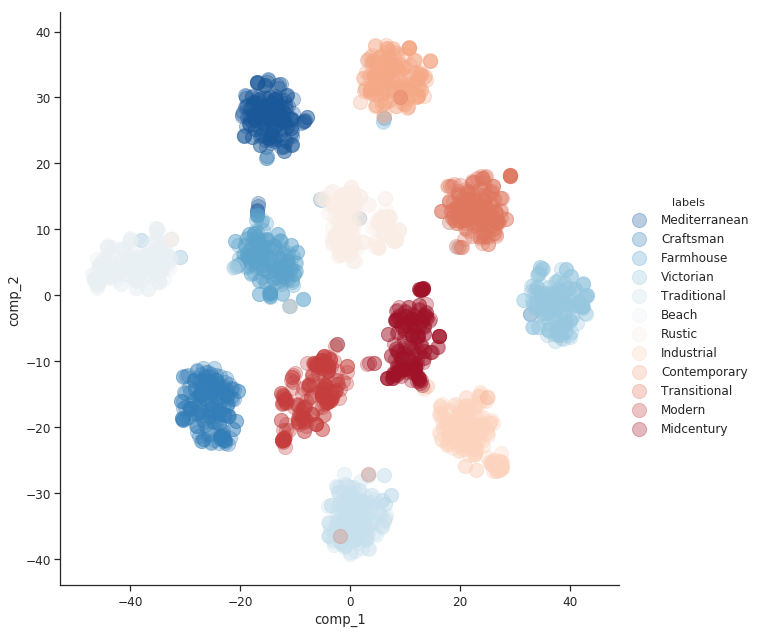

In [33]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

sns.set_palette(sns.color_palette("RdBu_r",12))

sns.lmplot(x='comp_1',
           y='comp_2',
           data=proj,
           fit_reg=False,
           legend=True,
           size=9,
           hue='labels',
           scatter_kws={"s":200, "alpha":0.3})

In [34]:
style_labels = set(label_array)
style_indices = {}
for style in style_labels:
    style_indices[style] = [i for i,label in enumerate(label_array) if label == style]

In [35]:
remove_indices = []
for style in style_labels:
    style_slice = style_indices[style]
    outliers = find_outliers(output_embedding[style_slice],0.2,75)
    style_remove = [val for i,val in enumerate(style_slice) if i in outliers]
    remove_indices += style_remove

In [36]:
get_nmi_score(image_datasets['train'],output_embedding,label_array,remove_indices)

[('Beach', 201), ('Rustic', 2)]
[('Contemporary', 196), ('Traditional', 2)]
[('Craftsman', 201)]
[('Farmhouse', 194), ('Traditional', 1)]
[('Industrial', 198), ('Midcentury', 1)]
[('Mediterranean', 196), ('Farmhouse', 1)]
[('Midcentury', 196), ('Industrial', 1)]
[('Modern', 201), ('Contemporary', 1)]
[('Rustic', 199), ('Farmhouse', 2)]
[('Traditional', 190), ('Victorian', 3)]
[('Transitional', 196), ('Traditional', 4)]
[('Victorian', 194), ('Mediterranean', 1)]


0.9696558284614303

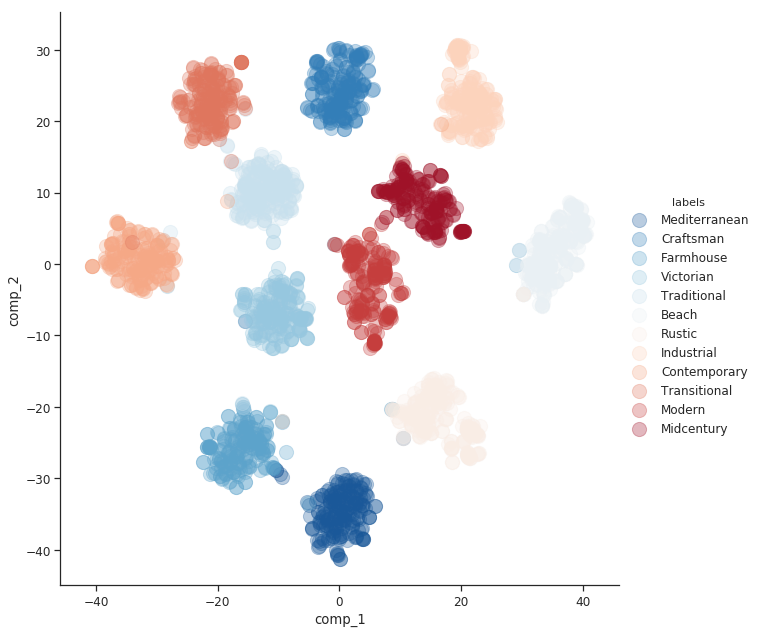

In [37]:
output_embedding_ = np.array([val for i,val in enumerate(output_embedding) if i not in remove_indices])
output_embedding_ = output_embedding_.astype(np.float64)
label_array_ = [val for i,val in enumerate(label_array) if i not in remove_indices]

output_2d = bh_sne(output_embedding_)

proj = pd.DataFrame(output_2d)
proj.columns = ["comp_1", "comp_2"]
proj['labels'] = label_array_


sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

sns.set_palette(sns.color_palette("RdBu_r",12))

sns.lmplot(x='comp_1',
           y='comp_2',
           data=proj,
           fit_reg=False,
           legend=True,
           size=9,
           hue='labels',
           scatter_kws={"s":200, "alpha":0.3})

In [38]:
remove_indices

[1180, 973, 1990, 861, 968, 1749]

In [39]:
len(markers)

NameError: name 'markers' is not defined

In [68]:
markers =  [u'd', u'h', u'+', u'*', u',', u'o', u'.', u'1', u'p', u'3', u'2', u'4']

In [56]:
def train_model(triplet_model, optimizer, loss_fn, device, dataloader, image_datasets, output_embedding, label_id_array,
                data_transforms, num_epochs, remove_indices=[]):
    
    for epoch in range(num_epochs):
    
        print("Creating batch hard triplets...")
        write_batch_hard(image_datasets=image_datasets,output_embedding=output_embedding,
                     label_id_array=label_id_array,phase='train',remove_indices=remove_indices)

        batch_hard_datasets = GetBatchHardest(img_path='./',
                                              txt_path1=Config.batch_ap_hard_path,
                                              txt_path2=Config.batch_an_hard_path,
                                              data_transforms=data_transforms['train'])


        batch_hard_dataloaders = DataLoader(batch_hard_datasets,
                            batch_size=30,
                            num_workers=4,
                            shuffle=False)
        print("Done")
    
        running_loss = 0.0
        
        for i,img_triplet in enumerate(batch_hard_dataloaders):
            
            anchor_img, pos_img, neg_img = img_triplet

            anchor_img, pos_img, neg_img = anchor_img.to(device), pos_img.to(device), neg_img.to(device)

            E1, E2, E3 = triplet_model(anchor_img, pos_img, neg_img)

            optimizer.zero_grad()

            #loss = F.triplet_margin_loss(E1,E2,E3)
            
            loss = loss_fn(E1,E2,E3)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img_triplet[0].size(0)

        epoch_loss = running_loss / len(batch_hard_dataloaders.dataset)

        
        output_embedding_,label_array = create_embeddings(triplet_model.embeddingNet.model,dataloader,image_datasets['train'])
        nmi_train_score = get_nmi_score(image_datasets['train'],output_embedding_,label_array,remove_indices)
                
        print('{} loss: {:.4f}, nmi_train_score: {:.4f}'.format(epoch, running_loss, nmi_train_score))
        #                                                running_loss,
        #                                                silhouette_val_score, silhouette_training_score))
        
        #wandb.log({'epoch_loss':running_loss,'val_score':nmi_val_score,'train_score':nmi_train_score})
        
        #print('{} loss: {:.4f}, val_score: {:.4f}, train_score: {:.4f}'.format(epoch,
        #                                                running_loss,
        #                                                silhouette_val_score, silhouette_training_score))
        
        
        
        

In [40]:
output_embedding__,label_array__ = create_embeddings(triplet_model.embeddingNet.model,
                                                     dataloader_list,
                                                     image_datasets['train'])

NameError: name 'triplet_model' is not defined

In [42]:
output_embedding__[0:2]

NameError: name 'output_embedding__' is not defined

In [44]:
def write_batch_hard(label_id_array,output_embedding,image_datasets,phase,remove_indices):

    batch_pos = []
    batch_neg = []

    label_id_array_shuffle = np.arange(len(label_id_array))
    np.random.shuffle(label_id_array_shuffle)

    for ind in label_id_array_shuffle:

        file_path = image_datasets[phase].samples[ind][0]
        label_id = label_id_array[ind]
        pred = np.asmatrix(output_embedding[ind])
        
        indices = np.argwhere(label_id_array == label_id).ravel()
        
        indices = np.array(list(set(indices).difference(set(remove_indices))))
        
        row = euclidean_distances(pred,output_embedding[indices])
        vals = np.argsort(-row)

        num_vals = int(len(vals[0])/10.)
        pos_choice = np.random.choice(num_vals)

        pos_ind = indices[vals[0][pos_choice]]
        pos_path = image_datasets[phase].samples[pos_ind][0]

        label_indices = set(label_id_array)
        label_indices.remove(label_id)

        indices = np.argwhere(label_id_array != label_id).ravel()
        indices = np.array(list(set(indices).difference(set(remove_indices))))
        
        row = euclidean_distances(pred,output_embedding[indices])
        vals = np.argsort(row)

        num_vals = int(len(vals[0])/10.)
        neg_choice = np.random.choice(num_vals)

        neg_ind = indices[vals[0][neg_choice]]
        neg_path = image_datasets[phase].samples[neg_ind][0]

        batch_pos += [(file_path,pos_path)]
        batch_neg += [(file_path,neg_path)]

    pd.DataFrame(batch_pos,columns=['anchor_image','positive_image'])\
        .to_csv(path_or_buf='batch_hard_pos_shuffle.csv',index=None)

    pd.DataFrame(batch_neg,columns=['anchor_image','negative_image'])\
        .to_csv(path_or_buf='batch_hard_neg_shuffle.csv',index=None)

In [45]:
def get_silhouette_score(model, dataloaders, phase, device):

    label_id_array = []
    
    for i,(inputs,labels) in enumerate(dataloaders[phase]):

        inputs = inputs.to(device)
     
        my_embedding = model(inputs)
    
        if i == 0:
            output_embedding = my_embedding[:,:,0,0].cpu().detach().numpy()
        else:
            output_embedding = np.vstack((output_embedding, my_embedding[:,:,0,0].cpu().detach().numpy()))
                    
        for j in range(len(inputs)):
            label_id_array += [labels[j].item()]
    
    label_id_array = np.asarray(label_id_array)
       
    return metrics.silhouette_score(output_embedding,label_id_array)
    

In [46]:
class GetBatchHardest(Dataset):
    def __init__(self, img_path, txt_path1, txt_path2, data_transforms=None):
        
        batch_pos_df = pd.read_csv(txt_path1)
        
        self.img_anchor = [os.path.join(img_path, line.strip()) for line in batch_pos_df['anchor_image'].values]
        self.img_positi = [os.path.join(img_path, line.strip()) for line in batch_pos_df['positive_image'].values]
        
        batch_neg_df = pd.read_csv(txt_path2)
        
        self.img_negati = [os.path.join(img_path, line.strip()) for line in batch_neg_df['negative_image'].values]

        self.data_transforms = data_transforms

    def __len__(self):
        return len(self.img_anchor)

    def __getitem__(self, item):
        img_anchor = self.img_anchor[item]
        img_positi = self.img_positi[item]
        img_negati = self.img_negati[item]
        
        img_a = Image.open(img_anchor).convert('RGB')
        img_p = Image.open(img_positi).convert('RGB')
        img_n = Image.open(img_negati).convert('RGB')
        
        if self.data_transforms is not None:
            try:
                img_a = self.data_transforms(img_a)
            except:
                print("Cannot transform image: {}".format(img_a))
            try:
                img_p = self.data_transforms(img_p)
            except:
                print("Cannot transform image: {}".format(img_s))
            try:
                img_n = self.data_transforms(img_n)
            except:
                print("Cannot transform image: {}".format(img_h))    
                
        return img_a, img_p, img_n

In [47]:
class TripletNet(nn.Module):
    def __init__(self, embeddingNet):
        super(TripletNet, self).__init__()
        self.embeddingNet = embeddingNet

    def forward(self, i1, i2, i3):
        E1 = self.embeddingNet.forward(i1)
        E2 = self.embeddingNet.forward(i2)
        E3 = self.embeddingNet.forward(i3)

        return E1, E2, E3

In [48]:
class Embedding(nn.Module):
    
    def __init__(self,filename, output_size, batch_size, device):
        
        super(Embedding, self).__init__()
        
        model = torch.load(filename)
        
        for param in model.parameters():
            param.requires_grad = False
        
        ct = []
        for name, child in model.named_children():
            if "layer1" in ct:
                for params in child.parameters():
                    params.requires_grad = True
            ct.append(name)
        
        
        model = ResNet50Bottom(model)
        
        model = model.to(device)
            
        model.train()
        
        self.model = model
        self.output_size = output_size
        self.batch_size = batch_size
        
    def forward(self, x):
        
        x = self.model(x)
        return x

In [49]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [58]:
embeddingNet = Embedding(filename='chandelierclassifier.pth',
                         output_size=2048,
                         batch_size=30,
                         device=device)


triplet_model = TripletNet(embeddingNet)

#criterion = torch.nn.TripletMarginLoss(margin=1.0,p=2)
loss_fn = TripletLoss(1)
optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, triplet_model.parameters())), lr=0.001, momentum=0.9)

num_epochs = 10

#wandb.init(project="homedepot")

In [51]:
class_labels = ['Beach','Craftsman','Industrial','Midcentury','Rustic','Transitional','Contemporary','Farmhouse',
                'Mediterranean','Modern','Traditional','Victorian']
label_id_array = [class_labels.index(item) for item in label_array]

In [52]:
label_id_array = np.array(label_id_array)

In [59]:
train_model(triplet_model, optimizer, loss_fn, device, dataloader_list, 
            image_datasets, output_embedding, label_id_array,
            data_transforms, num_epochs, remove_indices)          

Creating batch hard triplets...
Done
[('Farmhouse', 32), ('Craftsman', 31)]
[('Victorian', 40), ('Contemporary', 35)]
[('Transitional', 27), ('Craftsman', 24)]
[('Victorian', 34), ('Craftsman', 32)]
[('Rustic', 22), ('Industrial', 19)]
[('Transitional', 15), ('Mediterranean', 13)]
[('Midcentury', 25), ('Mediterranean', 19)]
[('Modern', 34), ('Industrial', 31)]
[('Mediterranean', 30), ('Midcentury', 25)]
[('Traditional', 54), ('Contemporary', 45)]
[('Midcentury', 17), ('Farmhouse', 16)]
[('Victorian', 23), ('Mediterranean', 22)]
0 loss: 41048.2129, nmi_train_score: 0.0395
Creating batch hard triplets...
Done
[('Craftsman', 34), ('Beach', 30)]
[('Contemporary', 41), ('Industrial', 31)]
[('Traditional', 37), ('Modern', 33)]
[('Rustic', 16), ('Farmhouse', 16)]
[('Industrial', 37), ('Modern', 36)]
[('Mediterranean', 22), ('Craftsman', 17)]
[('Midcentury', 29), ('Mediterranean', 16)]
[('Craftsman', 36), ('Transitional', 27)]
[('Rustic', 13), ('Transitional', 12)]
[('Traditional', 35), ('Indu

In [41]:
train_model(triplet_model, optimizer, device, dataloader_list, 
            image_datasets, output_embedding, label_id_array,
            data_transforms, num_epochs)

Creating batch hard triplets...
Done
Resuming run: https://app.wandb.ai/homedepot/homedepot/runs/225l05ht
0 loss: 580.0160, val_score: -0.0898, train_score: -0.0021
Creating batch hard triplets...
Done
1 loss: 290.2347, val_score: -0.0879, train_score: -0.0214
Creating batch hard triplets...
Done
2 loss: 304.5964, val_score: -0.0798, train_score: -0.0017
Creating batch hard triplets...
Done
3 loss: 383.2899, val_score: -0.1235, train_score: -0.0054
Creating batch hard triplets...
Done
4 loss: 235.5917, val_score: -0.1187, train_score: -0.0058
Creating batch hard triplets...
Done
5 loss: 254.6474, val_score: -0.0918, train_score: -0.0062
Creating batch hard triplets...
Done
6 loss: 211.4354, val_score: -0.0779, train_score: -0.0079
Creating batch hard triplets...
Done
7 loss: 232.0062, val_score: -0.1105, train_score: -0.0093
Creating batch hard triplets...
Done
8 loss: 103.8938, val_score: -0.1512, train_score: -0.0066
Creating batch hard triplets...
Done
9 loss: 191.8331, val_score: -

Done
85 loss: 25.4722, val_score: -0.1294, train_score: -0.0065
Creating batch hard triplets...
Done
86 loss: 28.7318, val_score: -0.1591, train_score: -0.0044
Creating batch hard triplets...
Done
87 loss: 39.5150, val_score: -0.1524, train_score: -0.0072
Creating batch hard triplets...
Done
88 loss: 24.8058, val_score: -0.1538, train_score: -0.0040
Creating batch hard triplets...
Done
89 loss: 30.3720, val_score: -0.1569, train_score: -0.0037
Creating batch hard triplets...
Done


Process Process-1224:
Process Process-1223:
Process Process-1221:


Cannot transform image: <PIL.Image.Image image mode=RGB size=412x990 at 0x7F6240C4EBE0>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/site-packages/torch/utils/data/da

KeyboardInterrupt: 

In [29]:
train_model(triplet_model=triplet_model, optimizer=optimizer, device=device, dataloaders=dataloaders, 
            batch_hard_dataloaders=batch_hard_dataloaders, num_epochs=num_epochs)

0
100
200
300
400
500
600
700
800
Resuming run: https://app.wandb.ai/homedepot/homedepot/runs/iq8z6520
0 loss: 0.0469, val_score: -0.0555, train_score: 0.1100
0
100
200
300
400
500
600
700
800
1 loss: 0.0006, val_score: -0.0511, train_score: 0.1170
0
100
200
300
400
500
600
700
800
2 loss: 0.0001, val_score: -0.0456, train_score: 0.1127
0
100
200
300
400
500
600
700
800
3 loss: 0.0001, val_score: -0.0455, train_score: 0.1112
0
100
200
300
400
500
600
700
800
4 loss: 0.0001, val_score: -0.0464, train_score: 0.1124
0
100
200
300
400
500
600
700
800
5 loss: 0.0000, val_score: -0.0464, train_score: 0.1132
0
100
200
300
400
500
600
700
800
6 loss: 0.0000, val_score: -0.0450, train_score: 0.1141
0
100
200
300
400
500
600
700
800
7 loss: 0.0000, val_score: -0.0493, train_score: 0.1161
0
100
200
300
400
500
600
700
800
8 loss: 0.0000, val_score: -0.0493, train_score: 0.1177
0
100
200
300
400
500
600
700
800
9 loss: 0.0000, val_score: -0.0456, train_score: 0.1154
0
100
200
300
400
500
600
700
8

0
100
200
300
400
500
600
700
800
90 loss: 0.0000, val_score: -0.0526, train_score: 0.1086
0
100
200
300
400
500
600
700
800
91 loss: 0.0000, val_score: -0.0526, train_score: 0.1087
0
100
200
300
400
500
600
700
800
92 loss: 0.0000, val_score: -0.0526, train_score: 0.1103
0
100
200
300
400
500
600
700
800
93 loss: 0.0000, val_score: -0.0526, train_score: 0.1100
0
100
200
300
400
500
600
700
800
94 loss: 0.0000, val_score: -0.0526, train_score: 0.1080
0
100
200
300
400
500
600
700
800
95 loss: 0.0000, val_score: -0.0526, train_score: 0.1093
0
100
200
300
400
500
600
700
800
96 loss: 0.0000, val_score: -0.0526, train_score: 0.1082
0
100
200
300
400
500
600
700
800
97 loss: 0.0000, val_score: -0.0526, train_score: 0.1100
0
100
200
300
400
500
600
700
800
98 loss: 0.0000, val_score: -0.0526, train_score: 0.1083
0
100
200
300
400
500
600
700
800
99 loss: 0.0000, val_score: -0.0526, train_score: 0.1081


In [34]:
for epoch in range(num_epochs):
    
    running_loss = 0.0
    
    for img_triplet in  batch_hard_dataloaders:
        
        anchor_img, pos_img, neg_img = img_triplet
        
        anchor_img, pos_img, neg_img = anchor_img.to(device), pos_img.to(device), neg_img.to(device)
        
        E1, E2, E3 = triplet_model(anchor_img, pos_img, neg_img)
        
        optimizer.zero_grad()
        
        loss = F.triplet_margin_loss(E1,E2,E3)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * img_triplet[0].size(0)
           
    epoch_loss = running_loss / len(batch_hard_dataloaders.dataset)
    
    print("Epoch number {}\n Current loss {}\n".format(epoch,running_loss))

        

Epoch number 0
 Current loss 1.5292988810688257

Epoch number 1
 Current loss 5.838844017125666

Epoch number 2
 Current loss 6.010209904052317

Epoch number 3
 Current loss 2.5941716821398586

Epoch number 4
 Current loss 4.516636035405099

Epoch number 5
 Current loss 1.6982212869334035

Epoch number 6
 Current loss 2.697974438779056

Epoch number 7
 Current loss 3.775315412785858



Process Process-96:
Process Process-95:
Process Process-93:


Cannot transform image: <PIL.Image.Image image mode=RGB size=510x640 at 0x7F34BCF41668>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/mhagen/Developer/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_

KeyboardInterrupt: 